In [1084]:
# This code tests the trained 3d dq stepper
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run 3d_ipm_env.ipynb #imports LIPM Env

In [1085]:
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 512)
        self.l5 = nn.Linear(512, 512)
        self.l6 = nn.Linear(512, 512)
        self.l7 = nn.Linear(512, 512)
        self.l8 = nn.Linear(512, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = F.relu(self.l7(x))
        x = self.l8(x)
        return x

In [1086]:
class DQStepper:
    def __init__(self, no_actions = [9, 7], lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        '''
        This is a 3d dq stepper.
        State = [x-ux, y-uy, z-uz, xd, yd, n, action_x, action_y, action_z]
        '''
        self.device = torch.device("cpu")
        self.dq_stepper = NN(11, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(11, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        assert len(no_actions) == 2
        self.no_actions = no_actions
        
        # This is the template of x_in that goes into the dq stepper
        self.max_step_height = 0.02
        self.delta = 2 #discretization of step height
        self.x_in = np.zeros((self.no_actions[0]*self.no_actions[1], 11))
        self.x_in[:,8] = np.tile(np.arange(self.no_actions[0]), self.no_actions[1])
        self.x_in[:,9] = np.repeat(np.arange(self.no_actions[1]), self.no_actions[0])
                  
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        self.x_in[:,10] = (1/(self.delta))*self.max_step_height*\
                            np.random.randint(-self.delta, self.delta+1, self.no_actions[0]*self.no_actions[1])
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
        return [action_x, action_y, action_z], q_values[action_index]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        self.x_in[:,10] = (1/(self.delta))*self.max_step_height*\
                            np.random.randint(-self.delta, self.delta+1, self.no_actions[0]*self.no_actions[1])
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
        return [action_x, action_y, action_z], q_values[action_index]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            action_x = np.random.randint(self.no_actions[0])
            action_y = np.random.randint(self.no_actions[1])
            action_z = 2*self.max_step_height*(np.random.rand() - 0.5)
            return [action_x, action_y, action_z]
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:11].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,11].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,12:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,12:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,12:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, e, figsize=(15,25), window = 500, title='history'):
        clear_output(wait=True)
        clear_output(wait=True)
        fig, ax = plt.subplots(3, 1, figsize=figsize)
        ax[0].plot(history['epi_cost'], label='epi_cost', color = 'orange')
        ax[0].grid(True)
        ax[0].legend() # the plot evolves to the right
        if e > window:
            ax[1].plot(np.arange(e-window+1, e), history['epi_cost'][e-window:], label='epi_cost zoom')
            ax[1].grid(True)
            ax[1].legend() # the plot evolves to the right
        ax[2].plot(history['loss'], label='loss', color = 'black')
        ax[2].grid(True)
        ax[2].legend() # the plot evolves to the right
        ax[2].set_ylim(0, 60)
        plt.xlabel('episode')
        plt.show();
        
    def predict_q(self, x, terrain):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        self.x_in[:,10] = terrain
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
            
        return q_values, [action_x, action_y, action_z] 

# this part is to test the new model

In [1043]:
ht = 0.28
max_step_length = [0.02, 0.2]
no_actions = [1,9]
env = InvertedPendulumEnv(ht, 0.13, max_step_length, [0.5, 3, 1.5], no_actions)
no_actions = [len(env.action_space_x), len(env.action_space_y)]
print(no_actions)
print(env.action_space_x)
print(env.action_space_y)

# dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/bolt/lipm_walking/dqs_3')
dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/dqs_1')

[3, 9]
[-0.02  0.    0.02]
[0.   0.04 0.09 0.13 0.17 0.21 0.27 0.34 0.43]


In [1044]:
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.2 ## time after which step is taken

v_des = [0.0, 0.0]
v_init = np.round([0.0*random.uniform(-1.0, 1.0), 0.3*random.uniform(-1.0, 1.0)], 2)
# v_init = [0, -0.0]
print(v_init)
state = env.reset_env([0.0, 0.0, ht, v_init[0], v_init[1]], v_des, no_steps*step_time)
epi_cost = 0
for n in range(no_steps):
    terrain = 0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
    action = dqs.predict_q(state, terrain)[1]
    next_state, cost, done = env.step_env(action, step_time)
    print(action, cost, done, state[3:5])
    epi_cost += cost
    state = next_state
    if done:
        print(epi_cost)
        break
print("showing episode...")
# env.show_episode(5)
# env.show_episode_side(5)


[-0.   -0.09]
[0, 4, -0.0] 1.3183520751590259 False [-0.   -0.09]
[2, 8, 0.0] 101.3139269371544 True [0.  0.4]
102.63227901231343
showing episode...


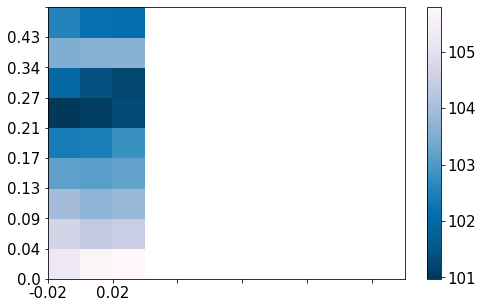

In [1045]:
def plot_heatmap_with_capture_region(x, terr, dqs, env):
    plt.rcParams.update({'font.size': 15})
    q_1 = dqs.predict_q(x, terr)[0]
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q_1)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_1[i]
    
    fig, ax = plt.subplots(figsize = (8,5))
    ax.set_xticklabels(env.action_space_x[::2])
    ax.set_yticklabels(env.action_space_y)
    heatmap = ax.pcolor(q_mat, cmap='PuBu_r')
    ax.set_xlim(0,11)
    ax.set_ylim(0,9)

    
    fig.colorbar(heatmap, ax=ax)
    plt.show()
    
x = [0, 0, 0.28, 0.0, 0.0, 1, 0, 0]

terrain = -0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
    
plot_heatmap_with_capture_region(x, terrain, dqs, env)

## Code for plots for Paper

In [1087]:
ht = 0.28
max_step_length = [0.22, 0.22]
no_actions = [11,9]
env = InvertedPendulumEnv(ht, 0.13, max_step_length, [0.5, 3, 1.5], no_actions)
no_actions = [len(env.action_space_x), len(env.action_space_y)]
print(no_actions)
print(env.action_space_x)
print(env.action_space_y)

dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/bolt/lipm_walking/dqs_3')

[11, 9]
[-0.26 -0.21 -0.16 -0.11 -0.05  0.    0.05  0.11  0.16  0.21  0.26]
[0.   0.04 0.09 0.13 0.17 0.22 0.28 0.36 0.46]


In [1090]:
# This block is to compare cpature regions with analytical capture region
def compute_dcm(state, ht):
    return state[0] + np.sqrt(ht/9.81)*state[1]

def infinite_capture_radius(step_time, max_step_length, ht):
    delta_t = np.sqrt(9.81/ht)*step_time
    return max_step_length*(np.power(np.e, -delta_t))/(1 - np.power(np.e, -delta_t))

def plot_heatmap_with_capture_region(x, next_x, terr, dqs, env):
    plt.rcParams.update({'font.size': 15})
    q_1 = dqs.predict_q(x, terr)[0]
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q_1)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_1[i]
    
    dcm_x = compute_dcm([next_x1[0], next_x1[3]], env.h)
    dcm_y = compute_dcm([next_x1[1], next_x1[4]], env.h)
#     print(dcm_x, dcm_y)
    fig, ax = plt.subplots(figsize = (8,5))
    rad = infinite_capture_radius(0.1, env.action_space_x[-1], env.h)
    capture_region = plt.Circle(( dcm_x/0.05 + 5, dcm_y/0.05 + 1), \
                                rad//0.05, fill = False, color = 'red', lw = 2.5)
    dcm = plt.Circle(( dcm_x/0.05 + 5, dcm_y/0.05 + 1), \
                                0.15, fill = True, color = 'red')
    # The +1 and +2 are to correct the offset due to heat map
    # move the circle a bit so that it avoids confusion in the paper (Kin circle should be outside the possinle
    #best actions, which is the case. the issue being that the x labels are not in between in the heatmap)
    kin_region = plt.Circle((next_x[0]/0.05 + 6, next_x[1]/0.05 + 1),\
                            np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)//0.05, fill = False, color = 'yellow', lw = 2.5)
    ax.add_patch(capture_region)
    ax.add_patch(kin_region)
    ax.add_patch(dcm)
    ax.set_xticklabels(env.action_space_x[::2])
    ax.set_yticklabels(env.action_space_y)
    heatmap = ax.pcolor(q_mat, cmap='PuBu_r')
    ax.set_xlim(0,11)
    ax.set_ylim(0,9)

    ax.vlines(4, 3, 7, color = 'white', lw = 3)
    ax.vlines(6, 2, 3, color = 'white', lw = 3 )
    ax.vlines(10, 2, 7, color = 'white', lw = 3 )
    ax.hlines(3, 4, 6, color = 'white', lw = 3 )
    ax.hlines(7, 4, 10, color = 'white', lw = 3 )
    ax.hlines(2, 6, 10, color = 'white', lw = 3 )

    
    fig.colorbar(heatmap, ax=ax)
    plt.show()

# env.show_episode(5)
# env.show_episode_side(5)



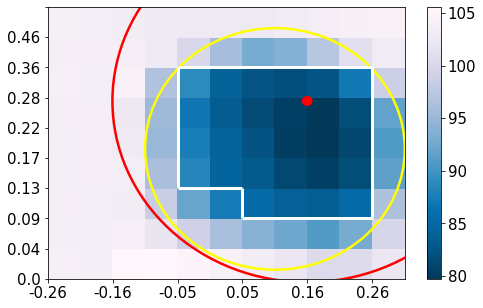

In [1091]:
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken

v_des = [0.0, 0]
v_init = [0.5, 0.2]
state = env.reset_env([0.0, 0.0, ht, v_init[0], v_init[1]], v_des, no_steps*step_time)
epi_cost = 0
history = {'state' : [], 'action' : [], 'next_state' : []}
for n in range(no_steps):
    terrain = 0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
    action = dqs.predict_q(state, terrain)[1]
    next_state, cost, done = env.step_env(action, step_time)
    history['state'].append(state)
    history['action'].append(action)
    history['next_state'].append(next_state)
#     print(action, cost, done, state[0:5])
    epi_cost += cost
    state = next_state
    if done:
        break
        
i = 0
x1 = history['state'][i].copy()
next_x1 = history['next_state'][i].copy()
next_x1[0] += env.action_space_x[int(history['action'][i][0])]
next_x1[1] += x1[5]*env.action_space_y[history['action'][i][1]] + 0.13/2.0

terrain_1 = -0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
plot_heatmap_with_capture_region(x1,next_x1, terrain_1,dqs, env)

# print(x1, next_x1, env.action_space_x[history['action'][i][0]], env.action_space_y[history['action'][i][1]])


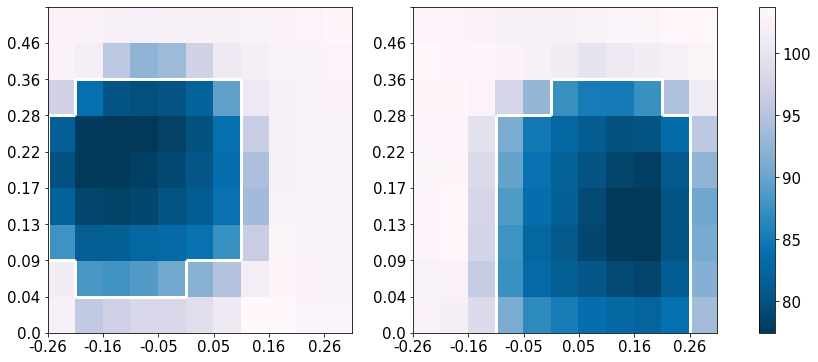

In [181]:
# This block is for visualising the output from the dqstepper
# This is for figure 3


def plot_heatmap(x1, x2, terr_1, terr_2, dqs, env):
    plt.rcParams.update({'font.size': 15})
    q_1 = dqs.predict_q(x1, terr_1)[0]
    q_2 = dqs.predict_q(x2, terr_2)[0]
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q_1)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_1[i]
    fig, ax = plt.subplots(1,2, figsize = (15, 6))
    ax[0].set_xticklabels(env.action_space_x[::2])
    ax[0].set_yticklabels(env.action_space_y)
    heatmap = ax[0].pcolor(q_mat, cmap='PuBu_r')
    
    ax[0].vlines(0, 2, 6, color = 'white', lw = 3)
    ax[0].vlines(1, 1, 2, color = 'white', lw = 3 )
    ax[0].vlines(1, 6, 7, color = 'white', lw = 3 )
    ax[0].vlines(5, 1, 2, color = 'white', lw = 3 )
    ax[0].vlines(7, 2, 7, color = 'white', lw = 3 )
    ax[0].hlines(1, 1, 5, color = 'white', lw = 3 )
    ax[0].hlines(2, 0, 1, color = 'white', lw = 3 )
    ax[0].hlines(6, 0, 1, color = 'white', lw = 3 )
    ax[0].hlines(7, 1, 7, color = 'white', lw = 3 )
    ax[0].hlines(2, 5, 7, color = 'white', lw = 3 )
    
    for i in range(len(q_2)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_2[i]
    ax[1].set_xticklabels(env.action_space_x[::2])
    ax[1].set_yticklabels(env.action_space_y)
    heatmap = ax[1].pcolor(q_mat, cmap='PuBu_r')
    
    ax[1].vlines(3, 0, 6, color = 'white', lw = 3)
    ax[1].vlines(10, 0, 6, color = 'white', lw = 3 )
    ax[1].vlines(5, 6, 7, color = 'white', lw = 3 )
    ax[1].vlines(9, 6, 7, color = 'white', lw = 3 )
#     ax[1].vlines(7, 2, 7, color = 'white', lw = 3 )
    ax[1].hlines(6, 3, 5, color = 'white', lw = 3 )
#     ax[1].hlines(2, 0, 1, color = 'white', lw = 3 )
    ax[1].hlines(6, 9, 10, color = 'white', lw = 3 )
    ax[1].hlines(7, 5, 9, color = 'white', lw = 3 )
#     ax[1].hlines(2, 5, 7, color = 'white', lw = 3 )
    
    fig.colorbar(heatmap, ax=ax)
    plt.show()


dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/bolt/lipm_walking/dqs_3')
# dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/bolt/bullet_walking/dqs_2')
    
x1 = [0, 0, 0.28, -0.5, 0.2, 1, 0, 0]
x2 = [0, 0, 0.28, 0.4, -0.1, 1, 0, 0]

terrain_1 = -0.02*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
terrain_2 = 0.03*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
plot_heatmap(x1, x2, terrain_1, terrain_2, dqs, env)

# x2 = [0, 0, 0.28, 0.5, 0, 1, 0, 0]
# terrain_2 = -0.5*np.ones(no_actions[0]*no_actions[1])
# plot_heatmap(x2, terrain_2, dqs, env)

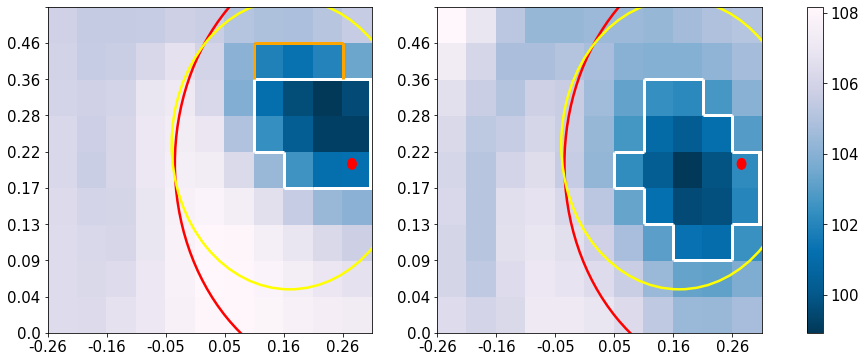

In [359]:
# This block is for visualising the output from the dq_stepper with the bullet stepper
# The hope is to show that the learned capture region in bullet is superior 
# This is for figure 4


def plot_heatmap(x1, next_x_lipm, next_x_bullet, terr_1, dqs_1, dqs_2, env):
    plt.rcParams.update({'font.size': 15})
    q_1 = dqs_1.predict_q(x1, terr_1)[0]
    q_2 = dqs_2.predict_q(x1, terr_1)[0]
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    
    
    
    for i in range(len(q_1)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_1[i]
    fig, ax = plt.subplots(1,2, figsize = (16, 6))
    ax[0].set_xticklabels(env.action_space_x[::2])
    ax[0].set_yticklabels(env.action_space_y)
    heatmap = ax[0].pcolor(q_mat, cmap='PuBu_r')
    
    dcm_x = compute_dcm([next_x_lipm[0], next_x_lipm[3]], env.h)
    dcm_y = compute_dcm([next_x_lipm[1], next_x_lipm[4]], env.h)
#     print(dcm_x, dcm_y)
    rad = infinite_capture_radius(0.1, env.action_space_x[-1], env.h)
    capture_region = plt.Circle(( dcm_x/0.05 + 5, dcm_y/0.05 + 1), \
                                rad//0.05, fill = False, color = 'red', lw = 2.5)
    dcm = plt.Circle(( dcm_x/0.05 + 5, dcm_y/0.05 + 1), \
                                0.15, fill = True, color = 'red')
    # The +1 and +2 are to correct the offset due to heat map
    # move the circle a bit so that it avoids confusion in the paper (Kin circle should be outside the possinle
    #best actions, which is the case. the issue being that the x labels are not in between in the heatmap)
    kin_region = plt.Circle((next_x_lipm[0]/0.05 + 6, (next_x_lipm[5]*0.13)/0.05 + next_x_lipm[1]/0.05 + 1),\
                            np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)//0.05, fill = False, color = 'yellow', lw = 2.5)
    
    ax[0].vlines(11, 4, 7, color = 'white', lw = 7 )
    ax[0].vlines(7, 5, 7, color = 'white', lw = 3 )
    ax[0].vlines(8, 4, 5, color = 'white', lw = 3 )
    ax[0].hlines(7, 7, 11, color = 'white', lw = 3 )
    ax[0].hlines(4, 9, 11, color = 'white', lw = 3 )
    ax[0].hlines(4, 8, 9, color = 'white', lw = 3 )
    ax[0].hlines(5, 7, 8, color = 'white', lw = 3 )
    
    ax[0].hlines(8, 7, 10, color = 'orange', lw = 3 )
    ax[0].vlines(7, 7, 8, color = 'orange', lw = 3 )
    ax[0].vlines(10, 7, 8, color = 'orange', lw = 3 )
    
    
    
    ax[0].add_patch(capture_region)
    ax[0].add_patch(kin_region)
    ax[0].add_patch(dcm)
    
    for i in range(len(q_2)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_2[i]
    ax[1].set_xticklabels(env.action_space_x[::2])
    ax[1].set_yticklabels(env.action_space_y)
    heatmap = ax[1].pcolor(q_mat, cmap='PuBu_r')
    
    dcm_x = compute_dcm([next_x_bullet[0], next_x_bullet[3]], env.h)
    dcm_y = compute_dcm([next_x_bullet[1], next_x_bullet[4]], env.h)
    rad = infinite_capture_radius(0.1, env.action_space_x[-1], env.h)
    capture_region = plt.Circle(( dcm_x/0.05 + 5, dcm_y/0.05 + 1), \
                                rad//0.05, fill = False, color = 'red', lw = 2.5)
    dcm = plt.Circle(( dcm_x/0.05 + 5, dcm_y/0.05 + 1), \
                                0.15, fill = True, color = 'red')
    # The +1 and +2 are to correct the offset due to heat map
    # move the circle a bit so that it avoids confusion in the paper (Kin circle should be outside the possinle
    #best actions, which is the case. the issue being that the x labels are not in between in the heatmap)
    kin_region = plt.Circle((next_x_bullet[0]/0.05 + 6, (next_x_bullet[5]*0.13)/0.05 + next_x_bullet[1]/0.05 + 1),\
                            np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)//0.05, fill = False, color = 'yellow', lw = 2.5)

    ax[1].vlines(6, 4, 5, color = 'white', lw = 3)
    ax[1].vlines(11, 3, 5, color = 'white', lw = 8 )
    ax[1].vlines(7, 5, 7, color = 'white', lw = 3 )
    ax[1].vlines(7, 3, 4, color = 'white', lw = 3 )
    ax[1].vlines(10, 2, 3, color = 'white', lw = 3 )
    ax[1].vlines(10, 5, 6, color = 'white', lw = 3 )
    ax[1].vlines(8, 2, 3, color = 'white', lw = 3 )
    ax[1].vlines(9, 6, 7, color = 'white', lw = 3 )
    ax[1].hlines(7, 7, 9, color = 'white', lw = 3 )    
    ax[1].hlines(6, 9, 10, color = 'white', lw = 3 )
    ax[1].hlines(2, 8, 10, color = 'white', lw = 3 )
    ax[1].hlines(3, 7, 8, color = 'white', lw = 3 )
    ax[1].hlines(5, 10, 11, color = 'white', lw = 3 )
    ax[1].hlines(3, 10, 11, color = 'white', lw = 3 )
    ax[1].hlines(4, 6, 7, color = 'white', lw = 3 )
    ax[1].hlines(5, 6, 7, color = 'white', lw = 3 )

    ax[1].add_patch(capture_region)
    ax[1].add_patch(kin_region)
    ax[1].add_patch(dcm)

    fig.colorbar(heatmap, ax=ax)
    plt.show()


dqs_1 = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/bolt/lipm_walking/dqs_3')
dqs_2 = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/bolt/bullet_walking/dqs_2')
    
x1 = [0.01, 0.03, 0.28, 1.0, 0.5, 1, 0, 0]
x1_next_lipm = [0.12, 0.08, 0.28, 1.03, 0.72, 1, 0, 0]
x1_next_bullet = [0.11, 0.08, 0.28, 0.92, 0.61, 1, 0, 0]


terrain_1 = 0.00*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
plot_heatmap(x1, x1_next_bullet, x1_next_bullet, terrain_1, dqs_1, dqs_2, env)


In [36]:
# This plots all the actions rated from best to worst
state = env.reset_env([0.0, 0.0, ht, v_init[0], v_init[1]], v_des, no_steps*step_time)
terrain = dqs.x_in[:,7:].copy()
terrain[:,3] = 0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
q_values, _ = dqs.predict_q(state, terrain[:,3])
terrain[:,0] = np.reshape(q_values, (len(terrain[:,0],)))
terrain = np.round(terrain[terrain[:,0].argsort()], 2)
print(terrain[0:71])


[[ 79.72   8.     4.    -0.  ]
 [ 79.79   8.     5.    -0.  ]
 [ 80.41   7.     4.     0.  ]
 [ 80.45   7.     5.     0.  ]
 [ 80.52   8.     3.     0.  ]
 [ 81.19   9.     4.     0.  ]
 [ 81.25   7.     3.    -0.  ]
 [ 81.58   6.     5.    -0.  ]
 [ 81.75   9.     5.    -0.  ]
 [ 81.79   9.     3.    -0.  ]
 [ 81.88   7.     6.    -0.  ]
 [ 82.25   6.     4.     0.  ]
 [ 82.46   6.     6.    -0.  ]
 [ 82.5    8.     6.     0.  ]
 [ 83.02   6.     3.     0.  ]
 [ 83.29   5.     5.     0.  ]
 [ 83.47   8.     2.     0.  ]
 [ 83.93   7.     2.     0.  ]
 [ 84.14   5.     6.     0.  ]
 [ 84.35   5.     4.    -0.  ]
 [ 84.56   5.     3.     0.  ]
 [ 85.3    6.     2.     0.  ]
 [ 85.35   9.     2.    -0.  ]
 [ 86.87   4.     5.    -0.  ]
 [ 87.1    9.     6.    -0.  ]
 [ 87.33   5.     2.    -0.  ]
 [ 87.54   4.     4.    -0.  ]
 [ 88.33   4.     3.    -0.  ]
 [ 88.86   4.     6.    -0.  ]
 [ 90.79  10.     4.     0.  ]
 [ 90.87   8.     1.     0.  ]
 [ 91.48  10.     3.     0.  ]
 [ 91.82

In [37]:
# This is a simulation of the episode where after taking the nth best action it checks if the IPM recovers
state = env.reset_env([0.0, 0.0, ht, v_init[0], v_init[1]], v_des, no_steps*step_time)
epi_cost = 0
history = {'state' : [], 'action' : [], 'next_state' : []}

action_number = 70

for n in range(no_steps):
    terrain = dqs.x_in[:,7:].copy()

    terrain[:,3] = 0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
    q_values, _ = dqs.predict_q(state, terrain[:,3])
    terrain[:,0] = np.reshape(q_values, (len(terrain[:,0],)))
    terrain = np.round(terrain[terrain[:,0].argsort()], 2)
    if n == 0:
        action = [int(terrain[action_number][1]),int(terrain[action_number][2]), terrain[action_number][3]] 
    else:
        action = [int(terrain[0][1]),int(terrain[0][2]), terrain[0][3]]
    next_state, cost, done = env.step_env(action, step_time)
    history['state'].append(state)
    history['action'].append(action)
    history['next_state'].append(next_state)
    print(action, cost, done, state[0:5])
    epi_cost += cost
    state = next_state
    if done:
        print('terminated ...')
        break
        
env.show_episode(10)

[2, 3, 0.0] 3.5435098793849926 False [0.   0.   0.28 0.5  0.2 ]
[10, 1, 0.0] 6.267945957244238 False [ 0.21 -0.03  0.28  0.59  0.47]
[10, 6, -0.0] 8.520176022718717 False [0.05 0.05 0.28 1.47 0.44]
[10, 3, 0.0] 7.241963937662687 False [-0.05 -0.17  0.28  1.91  0.7 ]
[10, 4, 0.0] 7.2375925559711485 False [-0.12 -0.    0.28  2.07  0.18]
[8, 5, -0.0] 6.537794675705875 False [-0.18 -0.15  0.28  2.01  0.21]
[8, 3, 0.0] 5.050001452254843 False [-0.16  0.06  0.28  1.71 -0.32]
[6, 6, 0.0] 5.077211490375879 False [-0.17 -0.09  0.28  1.42 -0.15]
[8, 4, -0.0] 3.0703068482173728 False [-0.1   0.16  0.28  1.05 -0.51]
[5, 3, -0.0] 1.787046982122943 False [-0.17 -0.04  0.28  0.87 -0.02]


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAo1W1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA1TZYiE
ADP//vbsvgU1/Z/QlxEsxdpKcD4qpICAdzTAAAADAAB5FfwRZP1AQSyZ4sUvBxlWVPVkxsPFpr8w
JrJNSa/MQeW7e/oWHszzX+XDpEUg0nrizKLfYdUX4jAQOWM9749LXikleE0AAAMADgki45yAZg64
A20N4oLxGKkfix4Y2nkPfU6Ypa3TbmkLfD2j0ga/THsRxsuNoDurB2+F7IA/YxcMWW6Lh3lnKXRq
uBTs7pc7yUjV/7JubMLMVxo5W19FGKlOMLLuJrFX88DZQ7m3hZ99d2kddtWoZrv3gFIblAEMua+P
ze/dlY21XL9KvaAJpCAyhEwcsECASCUs0TrRpQ2yExZLPaB9PV+ZjKUIsnAxbw6PYmMCysVqRi7V
Dl7Op6FSNQrpY1X6o0BYR+1uqc4hIbK66VwvQBXIya9PJ4MTe0bEBhkr7VQRBDhLHIwkdwmCPjj5
09tsvCvXlz1Fbud9ngngjjqmUUO4XZRHBmhhEY2XcuWJr9WBeGzhfkfiY0aSwpUAqzGvPAQ/KI0q
ci+WJuwi8KkeCOmwo7eUbeeVsSRpLr3Wq89OIPtD7+po5A7gBB6a/jfnAPCx9GBKHf/LUNo7c/24
O0Sy6hyXdOovQFmhdY2r3GVQ/o2OcdH2atXsaYmjazwFdp7K4tEe0/ZCbzxJt0JWXXi2FVUy9zF/
1IvEEjwv6rNDNlzEGs1a9RVkdivmuQEeNFI57eJR55a/2F2yxoapLvPqG9a1dK3UvkiNsw6xBwOE
s31rQ4dXeFyAwsXwxXnogLWOZQI23N1LtBnY7LfT8YRUcCYwlvUYvpqzOIxmf3nyG3drAvHOLH2X
Jez6snqG/PXzP+xR9HhNTwmhpR0jRwA7nWhATITFNT3C7Ic5h2ero2xIcNpdYn4r5U+5PVKJJi65
I+60t38OQkA9J6yTqfLoEzjNCstPkKN3y/IPhDZqPQfr7sYQa7wAX0/WTO/33zs2lnfGbE9yJpDc
Ork+WvXOOFk5qHcKF47vhfJijC+YYHCXYCJAFN82QA2BLDomNwe83KiJmuXhkYcqQuCJnwCTqm84
hE2Qt8GjR1CmpD5DRqUAvXEiLv0Zf7LdZAS6zWUAt4nBR4QfNS1vB16b01DmsD5GgwRZbE0vcNNO
kLTXlC5XG9F+UQ7i/WSu9NSIuXpdvgBwAI/Xj/+jGTehy8tJvZhlaQbX486wLmSW+xtfXfhKkUK9
+MYk8hi1A9/3yVb9XTxVo/xp4/TMIcbbXIsBifsFPsmWv4mggfX5uphfRrcA7ehkhBGw3boOWN7Q
oWETXPV5eSHncJtYrScn341xsMO3hK9C6aKxLl88587muve5lxUpV+wWb7UmKOTC/jqJOsPAEbr0
pFKTG5sPVpp/fm3c/vBf56/AQGxOZbAPi4wRnhcsS7/W2+tWpE2o4uc9mTGR2sR6RUiLJJHpvKFU
ChwCEb+FQD/+2oROjHlHr6KqHdH4i4qrZWjf2SDIgAoeqlpse5BSHf1avugJhfQrvKfSS5siKB9i
ywAFaYeEg1UUisKQYzBgk8TG1abHMyRimNy/zHfsXOoRWFTZn8QD/dA/s3ONg0piCdH/4RR2cgwO
ieauQrI9X5nDTSZRTHt1rLD4Q/Tk5T4kzm3ENFhzin+AAYPZKRPfnlPAW/KIpU/tib1ytG26HZ/5
vzD41hDHm7LnSVaOPSq99wzb5Qoyyab4Lvz20ElznecN03geRgeK2daiAdDCL/82CCn6VTkQB48D
pPJsWoQw+ZCTJWEL21z2POO1zb6Eqa2zeKy6z7CgqwioMiHC0KgE2dKO/3qtp5faU4UMzvyk9NaE
DfcLMytPuH3VAUzT/HvZS+Z74SWdz3sSIvIS4esaEHjnW6bl73IU5JsCuGhSGveENsyHOec4g1hW
+VBlF5fD34TGWK5jRvPT68EThcNEEQuopBg4IgC5nUgakcM0tmIjmggB7CAZMm68LWg7Bj5eYzF8
G4oWOZbiiIw61mHhR1+Hz9WKEkTZqXv9eUl+5MP9Qo5SIt5B5wecWAh3clpzaYR1oBdwG5xtrLX7
bJwmifsIfYVlcYcH9o2ujXV6h0Z4w4ni3GZHziTSlJcEvWBTRgWfQ/Zj4kuPTMkD0h9eNZsShopG
PifIgnMKrHLAxlMLszBnGKNhWumE0LP/+1xkRK/+bvu9j92tc2B1X6JyONwTkHP2I/tUkkZx5Agn
t4xADdQH2CKbnHqv2IwYB4RAJqI9xyhlOlfTLARZe18PkoFOdsKQPSXsAdIqakaJUA52tFQLpMp6
yI8wBzUP+gA8FIt10qGmCqCT1qRdHnJ+pL0bWMrYVcVLrisSvmwTZYgbZGQ8BSnXt6wCzwx5fnxM
h2TfzdUmJtjLLGQGno81yZf8P8wFBLHqxGxA2QKCJ6fBAHyuNOLZZ89VgwlQwfne9mK8b6VBfxJr
6nR1h0rbIaXYUZ6FbYxEYyZNGu4DeB6AwsabpWcV13PBz8lkp5TpLtWYbADxq9MhNYDCjO3IlZ1i
cFKKdfx1FejgQIYQ1Z1jtz1+FpqBuLri5vWMft04o58kRcXUvFm0OFgPtCLY0pmqNVCJgAbThjkW
wEoJS3WcK0Gj2XU2kyoPJCmYTK5jLaw/rBt6/l93uu5F8Z1WZl6kasjA1cQJf55stImO7YDMevnn
l/3dUINKFVp02qR7CgqUkj0d8z43DFQhkd+wL5nyOz74hvITPDZQWImDjwZjHo36YXNvUrXxjiwd
zgVL8Yw730OqR0jfA/azqleqAXLW3/YUrTfSrepunM8pj1uf5of/PmN0GEL/IiGyI5mJP7ieso4m
q0ZWhpnhwUM3uZR68Y72QmTJsKdEW+pXeGjYh8OSWAAIOk3u5fs8/rX4+6JzuZl+pfZm0c1fFfbl
jCG3nKbOgwIEoaOA0cIqO